## 이미지 노이즈 제거


In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Conv2D, Conv2DTranspose, Input
from tensorflow.keras.losses import MeanSquaredError
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

### 데이터 로드

In [ ]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


### 데이터 전처리

In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


### 임의의 노이즈 추가

In [ ]:
noise_factor = 0.2

x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

### 노이즈가 추가된 이미지 확인

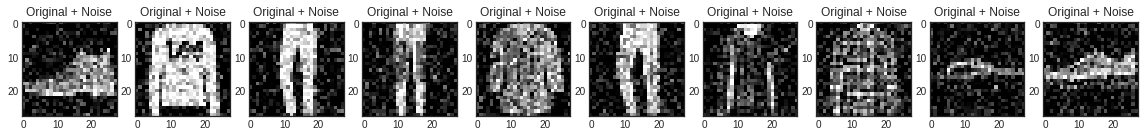

In [ ]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
  ax = plt.subplot(1, n, i+1)
  plt.title("Original + Noise")
  plt.imshow(tf.squeeze(x_test_noisy[i]))
  plt.gray()
plt.show()

### 모델 정의

In [ ]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()

    self.encoder = Sequential([Input(shape=(28, 28, 1)),
                               Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
                               Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])
    self.decoder = Sequential([Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
                               Conv2DTranspose(16, kernel_size=2, strides=2, activation='relu', padding='same'),
                               Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

### 모델 생성 및 컴파일

In [ ]:
autoencoder = Denoise()
autoencoder.compile(optimizer='adam', loss=MeanSquaredError())

### 모델 학습

In [ ]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0176 - val_loss: 0.0103
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0097 - val_loss: 0.0094
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0089 - val_loss: 0.0086
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0083 - val_loss: 0.0082
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0081 - val_loss: 0.0080
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0079 - val_loss: 0.0079
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0078 - val_loss: 0.0078
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0077 - val_loss: 0.0077
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.007

### 인코더 요약

In [ ]:
autoencoder.encoder.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 8)           1160      
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


### 디코더 요약

In [ ]:
autoencoder.decoder.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_4 (Conv2DTr (None, 14, 14, 8)         584       
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 28, 28, 16)        528       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 1)         145       
Total params: 1,257
Trainable params: 1,257
Non-trainable params: 0
_________________________________________________________________


### 노이즈가 있는 이미지와 없는 이미지 시각화

In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

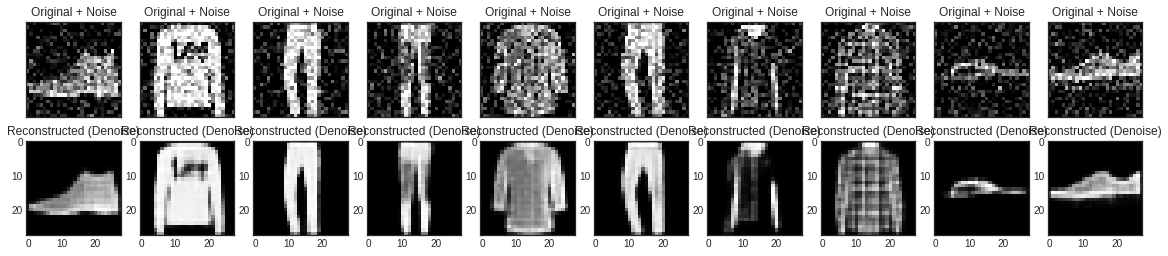

In [ ]:
n = 10
plt.figure(figsize=(20, 4)) 

for i in range(n):
  ax = plt.subplot(2, n, i+1)
  plt.title('Original + Noise')
  plt.imshow(tf.squeeze(x_test_noisy[i]))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  bx = plt.subplot(2, n, i+1+n)
  plt.title('Reconstructed (Denoise)')
  plt.imshow(tf.squeeze(decoded_imgs[i]))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()